# Number of samples

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from itertools import product as itproduct

In [3]:
from neuroprobnum.utils import math_utils
from neuroprobnum.utils import plot_utils as pltu

# Model

In [4]:
from neuroprobnum.models.hodgkin_huxley import compile_cython
compile_cython()

running build_ext



In [5]:
from neuroprobnum.models.hodgkin_huxley import HHNeuron

neuron = HHNeuron()
neuron

HH_neuron

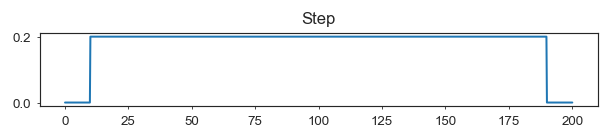

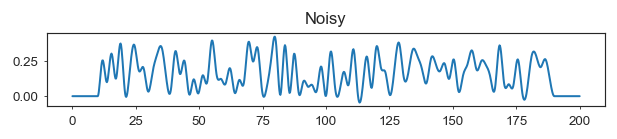

In [6]:
from neuroprobnum.utils import stim_utils

t0, tmax = 0, 200
stim_onset, stim_offset = 10, tmax-10
stims = [
    stim_utils.IStimStep(Iamp=0.2, onset=stim_onset, offset=stim_offset, name='Step'),
    stim_utils.IStimNoisy(Iamp=0.2, onset=stim_onset, offset=stim_offset, name='Noisy', nknots=101, seed=46),

]
for stim in stims: stim.plot(t0=t0, tmax=tmax)

# Data

## Generator

In [7]:
from neuroprobnum.generator.generator_hh import DataGeneratorHH
from copy import deepcopy

gens = {}

for stim in stims:
    
    neuron = deepcopy(neuron)
    neuron.get_Istim_at_t = stim.get_I_at_t
    
    gens[stim] = DataGeneratorHH(
        y0=neuron.compute_yinf(-65), t0=t0, tmax=tmax,
        t_eval_adaptive=math_utils.t_arange(t0, tmax, 1),
        model=neuron, n_samples=300, n_parallel=20, dt_min_eval_fixed=0.1,
        gen_det_sols=True, gen_acc_sols=True, acc_same_ts=True,
        base_folder='data',
    )
    gens[stim].update_subfoldername(stim=stim.name)
    gens[stim].load_acc_sols_from_file()    

## Generate data

In [8]:
# pert_method, adaptive, methods, step_params, pert_params
solver_params = [
    ('abdulle_ln', 0, ['EE'], [0.1], [1]),
    ('conrad', 1, ['RKBS'], [1e-2], [1]),
]

In [9]:
for stim, gen in gens.items():
    
    print('----------------------------------------------------------')
    print(stim, ':', gen.subfoldername)
    print('----------------------------------------------------------')   
    
    for pert_method, adaptive, methods, step_params, pert_params in solver_params:
        for method, step_param, pert_param in itproduct(methods, step_params, pert_params):
            gen.gen_and_save_data(
                method=method, adaptive=adaptive, step_param=step_param,
                pert_method=pert_method, pert_param=pert_param,
                overwrite=False, plot=True,
            )

----------------------------------------------------------
IStimStep(0.2,t=[10,190]) : stim_Step_tmax_200
----------------------------------------------------------
                                 EE_f(0.1)_abdulle_ln(1).pkl --> Data already exists.
                                  RKBS_a(0.01)_conrad(1).pkl --> Data already exists.
----------------------------------------------------------
IStimNoisy(0.2,t=[10,190],I=[0.00,0.00]) : stim_Noisy_tmax_200
----------------------------------------------------------
                                 EE_f(0.1)_abdulle_ln(1).pkl --> Data already exists.
                                  RKBS_a(0.01)_conrad(1).pkl --> Data already exists.


# Load data

In [10]:
from neuroprobnum.generator.dataloader import DataLoader

df = pd.DataFrame()
for stim, gen in gens.items():
    stim_df = DataLoader(gen).load_data2dataframe(solver_params, drop_traces=False, MAEs=False)
    stim_df['stimfun'] = stim
    stim_df['stim'] = stim.name
    df = df.append(stim_df, ignore_index=True)

In [11]:
df.head()

,acc_ts,acc_vs,adaptive,det_nODEcalls,det_run_time,det_ts,det_vs,method,nODEcalls,n_samples,pert_method,pert_param,run_times,step_param,t0,tmax,ts,vs,stimfun,stim
0,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[-65.0, -64.99996862359615, -64.99993891373829...",0,2000.0,0.048086,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[-65.0, -64.99996870091516, -64.99993945138549...",EE,"[2000, 2000, 2000, 2000, 2000, 2000, 2000, 200...",300,abdulle_ln,1.0,"[0.06821441650390625, 0.06435251235961914, 0.0...",0.10,0.0,200.0,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[[-65.0, -64.99997195034447, -64.9999381076709...","IStimStep(0.2,t=[10,190])",Step
1,"[0.0, 1.0, 2.0, 2.9999999999999787, 3.99999999...","[-65.0, -64.9997390179966, -64.99956670409958,...",1,2707.0,0.080314,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-65.0, -64.99973714654396, -64.99958651618194...",RKBS,"[3612, 3568, 3676, 3624, 3680, 3568, 3584, 363...",300,conrad,1.0,"[0.09685277938842773, 0.10102248191833496, 0.1...",0.01,0.0,200.0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[-65.0, -64.99974478827235, -64.9995810236783...","IStimStep(0.2,t=[10,190])",Step
2,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[-65.0, -64.99996862359615, -64.99993891373829...",0,2000.0,0.085279,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[-65.0, -64.99996870091516, -64.99993945138549...",EE,"[2000, 2000, 2000, 2000, 2000, 2000, 2000, 200...",300,abdulle_ln,1.0,"[0.10034036636352539, 0.10270214080810547, 0.1...",0.10,0.0,200.0,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[[-65.0, -64.99997195034447, -64.9999381076709...","IStimNoisy(0.2,t=[10,190],I=[0.00,0.00])",Noisy
3,"[0.0, 1.0, 2.0, 2.9999999999999787, 3.99999999...","[-65.0, -64.9997390179966, -64.99956670409958,...",1,2908.0,0.130982,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-65.0, -64.99973714654396, -64.99958651618194...",RKBS,"[3696, 3840, 3860, 3724, 3820, 3924, 3756, 383...",300,conrad,1.0,"[0.16257929801940918, 0.17054176330566406, 0.1...",0.01,0.0,200.0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[-65.0, -64.99974478827235, -64.9995810236783...","IStimNoisy(0.2,t=[10,190],I=[0.00,0.00])",Noisy


In [12]:
def bootstrap_MAE_SM(samples, n_samples, n_boot, average_fun=np.mean):
    MAE_SM_boot = np.empty(n_boot)
    
    for i in range(n_boot):
        idxs = np.random.choice(np.arange(0, samples.shape[0]), n_samples, replace=False)
        MAE_SM_boot[i] = average_fun(metric_utils.compute_sample_sample_distances(samples=samples[idxs, :]))
    
    return MAE_SM_boot

In [13]:
from neuroprobnum.utils import metric_utils

# Parameters
n_samples_list = [2, 3, 5, 10, 20]
n_boot = 1000
average_fun = np.mean

# Bootstrap
df['avg_MAE_SM'] = None
for n in n_samples_list:
    df[f'avg_MAE_SM_n{n}'] = None
    df[f'avg_MAE_ratio_SM_n{n}'] = None

for i, row in df.iterrows():
    df.at[i, 'avg_MAE_SM'] = average_fun(metric_utils.compute_sample_sample_distances(samples=row.vs))
    
    for n in n_samples_list:
        MAE_SM_n = bootstrap_MAE_SM(samples=row.vs, n_samples=n, n_boot=n_boot, average_fun=np.mean)
            
        df.at[i, f'avg_MAE_SM_n{n}'] = np.asarray(MAE_SM_n)
        df.at[i, f'avg_MAE_ratio_SM_n{n}'] = df.at[i, f'avg_MAE_SM_n{n}'] / df.at[i, 'avg_MAE_SM']

In [14]:
df.head()

,acc_ts,acc_vs,adaptive,det_nODEcalls,det_run_time,det_ts,det_vs,method,nODEcalls,n_samples,...,avg_MAE_SM_n2,avg_MAE_ratio_SM_n2,avg_MAE_SM_n3,avg_MAE_ratio_SM_n3,avg_MAE_SM_n5,avg_MAE_ratio_SM_n5,avg_MAE_SM_n10,avg_MAE_ratio_SM_n10,avg_MAE_SM_n20,avg_MAE_ratio_SM_n20
0,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[-65.0, -64.99996862359615, -64.99993891373829...",0,2000.0,0.048086,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[-65.0, -64.99996870091516, -64.99993945138549...",EE,"[2000, 2000, 2000, 2000, 2000, 2000, 2000, 200...",300,...,"[7.260742674100195, 15.283938662511154, 11.148...","[0.9028205438167053, 1.9004466119107462, 1.386...","[12.47084635687744, 8.447582125611602, 5.55610...","[1.5506590434519094, 1.0503953976754996, 0.690...","[7.351253635980706, 8.224143540220537, 9.54095...","[0.9140749236362549, 1.0226124346609902, 1.186...","[7.2310206732087945, 10.986049486181486, 8.186...","[0.8991248291753073, 1.366035351575212, 1.0178...","[8.351444083719123, 6.772232451501805, 7.65103...","[1.0384413313824676, 0.8420778505933905, 0.951..."
1,"[0.0, 1.0, 2.0, 2.9999999999999787, 3.99999999...","[-65.0, -64.9997390179966, -64.99956670409958,...",1,2707.0,0.080314,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-65.0, -64.99973714654396, -64.99958651618194...",RKBS,"[3612, 3568, 3676, 3624, 3680, 3568, 3584, 363...",300,...,"[10.540491477982407, 4.042916778486294, 7.9355...","[1.999394298273349, 0.7668887899757044, 1.5052...","[4.254398505157103, 3.996394117080573, 7.78025...","[0.8070041260943154, 0.758064045498713, 1.4758...","[2.942153005732558, 7.462679500523865, 5.32658...","[0.5580882026798495, 1.4155733510487947, 1.010...","[6.587191483711886, 4.069589497723691, 5.85062...","[1.2495046480213368, 0.7719482583006962, 1.109...","[5.64821265673273, 5.282265317697582, 6.187689...","[1.071392563135815, 1.0019771070668506, 1.1737..."
2,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[-65.0, -64.99996862359615, -64.99993891373829...",0,2000.0,0.085279,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[-65.0, -64.99996870091516, -64.99993945138549...",EE,"[2000, 2000, 2000, 2000, 2000, 2000, 2000, 200...",300,...,"[2.5394385301793387, 2.6252796539823895, 3.110...","[0.8313149747495773, 0.8594160730115498, 1.018...","[3.2332636073828254, 4.015318852304715, 3.7762...","[1.0584467480456636, 1.3144617011381103, 1.236...","[3.7843223452979977, 4.352623982197644, 2.5800...","[1.2388422864102537, 1.4248824899098866, 0.844...","[2.683804805505878, 3.0091311927288795, 3.2797...","[0.8785749675005328, 0.9850743744228028, 1.073...","[2.5351811277322867, 2.3944241895629745, 2.449...","[0.8299212641455566, 0.7838428302282032, 0.801..."
3,"[0.0, 1.0, 2.0, 2.9999999999999787, 3.99999999...","[-65.0, -64.9997390179966, -64.99956670409958,...",1,2908.0,0.130982,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-65.0, -64.99973714654396, -64.99958651618194...",RKBS,"[3696, 3840, 3860, 3724, 3820, 3924, 3756, 383...",300,...,"[3.5944657494348795, 2.2405304728044366, 2.582...","[1.336182163849107, 0.8328795053318764, 0.9600...","[1.0226762980428101, 2.500511131124185, 2.4123...","[0.38016270680861936, 0.9295229407707069, 0.89...","[2.310486558176395, 2.582565695259114, 2.70380...","[0.8588845030262937, 0.9600253443829104, 1.005...","[2.9570546720626005, 2.2096786814309852, 2.385...","[1.099235320564097, 0.8214108709840653, 0.8866...","[2.9925279941257807, 2.9559993505046114, 2.246...","[1.1124219311864818, 1.0988430225311745, 0.834..."


# Figure

In [15]:
stim2color = {}
stim2color[stims[0].name] = 'dimgray'
stim2color[stims[1].name] = 'black'

## Plot functions

How many samples are needed to get a good estimate of the SS distance and therefore a estimate for the SR distance.

In [16]:
def plot_R_distribution(ax, df, transform=None, lb=None, ub=None):
    """Plot R distributions as violins as a function of the stimulus and sample number"""
    assert df.method.nunique() == 1
    assert df.adaptive.nunique() == 1
    assert df.pert_method.nunique() == 1
    assert df.step_param.nunique() == 1
    
    if transform is None: transform = lambda x: x
    
    # Plot ratio distribution
    plot_df = pd.DataFrame()
    for _, row in df.iterrows():
        plot_df = plot_df.append(pd.DataFrame({
            'n': np.repeat(n_samples_list, n_boot),
            'stim': np.repeat(row.stim, n_boot*len(n_samples_list)),
            'R': transform(np.concatenate([row[f'avg_MAE_ratio_SM_n{n}'] for n in n_samples_list])),
        }))

    sns.violinplot(
        ax=ax, data=plot_df, x='n', y='R', hue='stim', scale="width",
        hue_order=[stim.name for stim in stims],
        palette=[stim2color[stim.name] for stim in stims],
        split=False, cut=0, linewidth=0.1, width=0.8, inner=None,
    )
    ax.legend().set_visible(False)
    
    if lb is not None and ub is not None:
        ax.axhline(transform(lb), color='gray', ls=':', alpha=1.0, zorder=-1000)
        ax.axhline(transform(1), color='gray', ls='-', alpha=1.0, zorder=-1000)
        ax.axhline(transform(ub), color='gray', ls=':', alpha=1.0, zorder=-1000)
    
    ax.set_xlabel('Number of samples')
    ax.set_xticks(np.arange(len(n_samples_list)))
    ax.set_xticklabels(n_samples_list)

In [17]:
from matplotlib.ticker import FuncFormatter

def plot_R_summary(ax, rows, lb, ub, marker, ls):
    for _, row in rows.iterrows():
        percentages = []
        for n in n_samples_list:
            percentages.append(
                np.mean((row[f'avg_MAE_ratio_SM_n{n}'] >= lb) & (row[f'avg_MAE_ratio_SM_n{n}'] <= ub))
            )
    
        ax.plot(percentages, color=stim2color[row.stim], marker=marker, ls=ls, label=row.stim, clip_on=False)
        print(row.stim, percentages)
        
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.set_xticks(np.arange(len(n_samples_list)))
    ax.set_xticklabels(n_samples_list)
    ax.set_xlabel('Number of samples')

# Plot

Step [0.565, 0.739, 0.961, 0.997, 1.0]
Noisy [0.706, 0.744, 0.814, 0.929, 0.993]
Step [0.503, 0.672, 0.867, 0.981, 1.0]
Noisy [0.503, 0.609, 0.732, 0.883, 0.983]


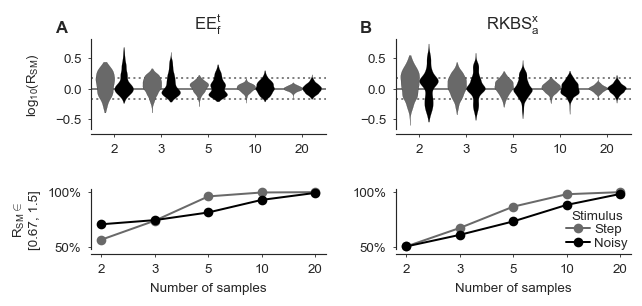

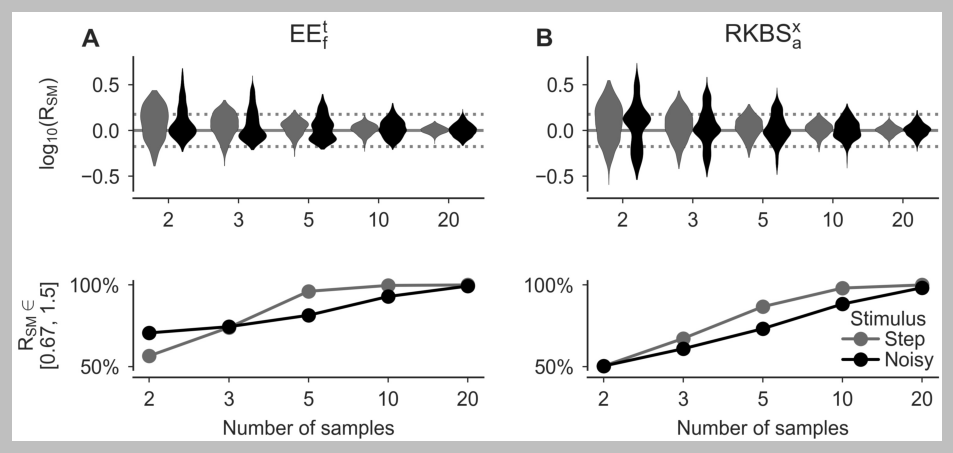

In [18]:
### Metric parameters ###
lb, ub = 2/3, 3/2

df_methods = df.groupby(['method', 'pert_method', 'adaptive'], sort=False)

fig, axs = pltu.subplots(len(df_methods), 2, yoffsize=0.4, ysizerow=1., squeeze=False, xsize='text', gridspec_kw=dict(height_ratios=[1.5, 1]))
sns.despine()
pltu.set_labs(axs[0, :], panel_nums='auto', panel_num_space=5, panel_num_va='top', panel_num_y=1.1)

### Plot data ###
for ax_col, ((method, pert_method, adaptive), df_method) in zip(axs.T, df_methods):
    # Plot R distributions
    plot_R_distribution(ax=ax_col[0], df=df_method, transform=np.log10, lb=lb, ub=ub)
    ax_col[0].set_ylabel(pltu.text2mathtext('log_{10} (R_SM )'))
    # Plot R in bounds
    plot_R_summary(ax_col[1], rows=df_method, lb=lb, ub=ub, marker='o', ls='-')
    ax_col[1].set_ylabel(pltu.text2mathtext('R_SM \in') + '\n' + f'[{lb:.2f}, {ub:.1f}]')
                       
#### Decorate ###
for ax_col, ((method, pert_method, adaptive), _) in zip(axs.T, df_methods):
    ax_col[0].set_title(pltu.method2label(method=method, adaptive=adaptive, pert_method=pert_method)) 

for ax in axs[:, 1:].flat:
    ax.set(ylabel=None)
    
for ax in axs[:-1, :].flat:
    ax.set(xlabel=None)
    
pltu.make_share_ylims(axs[0])
pltu.make_share_ylims(axs[1])
pltu.move_xaxis_outward(axs)

plt.tight_layout(h_pad=2.5, pad=0.2, w_pad=2)
fig.align_labels()

axs[1, -1].legend(loc='lower right', title='Stimulus', bbox_to_anchor=(1, -0.05))

pltu.savefig('fig7a_b')
pltu.show_saved_figure(fig)
plt.show()